### **SIMPLE SEARCH ENGINE IN NEWS GROUP**
_____________________________________________________
sistem yang dibuat merupakan sistem search engine pada semantic dokumen menggunakan metode **TF-IDF** dan **Google USE (Universal Setence Encoder)** lalu membandingkan perbedaan keduanya dari segi performa dan hasil yang dikeluarkan


##### **Import library**

In [1]:
import pandas as pd
import numpy as np
import os 
import re
import operator
import nltk 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##### **Document collection**
____________________________________
data that using from news crawler that has been save in json format

In [3]:
news = pd.read_json('https://raw.githubusercontent.com/zayedrais/DocumentSearchEngine/master/data/newsgroups.json')
news.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


##### **Document pre-processing**

###### case folding

In [4]:
for i,txt in enumerate(news['content']):
    #print(i)
    subject = re.findall('Subject:(.*\n)',txt)
    if (len(subject) !=0):
        news.loc[i,'Subject'] =str(i)+' '+subject[0]
    else:
        news.loc[i,'Subject'] ='NA'

In [5]:
df_news =news[['Subject','content']]

In [6]:
# Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df_news['content']=[entry.lower() for entry in df_news['content']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
SW=['subject:','organization:','thanks','thank','re:']

In [8]:
for sw in SW:
    df_news.content=df_news.content.replace(to_replace=sw,value='',regex=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
## data Cleaning for content data of news
df_news.content =df_news.content.replace(to_replace='from:(.*\n)',value='',regex=True) #remove from to email 
df_news.content =df_news.content.replace(to_replace='lines:(.*\n)',value='',regex=True)
df_news.content =df_news.content.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) #remove punctuation except
df_news.content =df_news.content.replace(to_replace='-',value=' ',regex=True)
df_news.content =df_news.content.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.content =df_news.content.replace(to_replace='  ',value='',regex=True)                #remove double white space
df_news.content =df_news.content.apply(lambda x:x.strip())  # Ltrim and Rtrim of whitespace

In [10]:
## data cleaning for subject data 
df_news.Subject =df_news.Subject.replace(to_replace='Re:',value='',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',value=' ',regex=True)
df_news.Subject =df_news.Subject.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
df_news.Subject =df_news.Subject.replace(to_replace='  ',value='',regex=True)    #remove double white space
df_news.Subject =df_news.Subject.apply(lambda x:x.strip())

In [11]:
df_news.head(5)

,Subject,content
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...
2,2 PB questions,pb questions... purdue university engineering ...
3,3 Weitek P9000,weitek p9000 harris computer systems division ...
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...


###### checking empty rows

In [12]:
## ## Checking  and drop empty data
for i,sen in enumerate(df_news.content):
    if len(sen.strip()) ==0:
        print(str(i))
        #file_data.text[i] = np.nan
        df_news=df_news.drop(str(i),axis=0).reset_index().drop('index',axis=1)

###### tokenization

___________________________________________________________________
Tokenization : In this each entry in the file_data will be broken into set of words

In [13]:
df_news['Word tokenize']= [word_tokenize(entry) for entry in df_news.content]
df_news.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subject,content,Word tokenize
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...,"[what, car, is, this, nntp, posting, host, rac..."
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...,"[si, clock, poll, final, call, summary, final,..."
2,2 PB questions,pb questions... purdue university engineering ...,"[pb, questions, ..., purdue, university, engin..."
3,3 Weitek P9000,weitek p9000 harris computer systems division ...,"[weitek, p9000, harris, computer, systems, div..."
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...,"[shuttle, launch, question, smithsonian, astro..."


###### lemmatize/stemming
_____________________________________________________________
Find the root of word

In [14]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words)
                #file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                #file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [ ]:
## This Function took around 13 hours for word Lemmatized and remove the Stop words & single character of word of each 11314 rows.
df_clean = wordLemmatizer(df_news['Word tokenize']) 
df_clean=df_clean.replace(to_replace ="\[.", value = '', regex = True)
df_clean=df_clean.replace(to_replace ="'", value = '', regex = True)
df_clean=df_clean.replace(to_replace =" ", value = '', regex = True)
df_clean=df_clean.replace(to_replace ='\]', value = '', regex = True)
df_clean

In [ ]:
data = pd.concat([df_news, df_clean], axis=1, join='inner')
data = data.rename(columns={'Keyword_final': 'Clean_Keyword'})

###### save to csv clean document


In [ ]:
data.to_csv("DocumentSearchEngine_NewsGroup_Final.csv", index=False, header=True)

#### **TF-IDF METHOD**

In [ ]:
df_news = pd.read_csv("DocumentSearchEngine_NewsGroup_Final.csv")
df_news = df_news.drop(['Word tokenize'],axis=1)

In [ ]:
df_news.head()

,Subject,content,Clean_Keyword
0,0 WHAT car is this,what car is this nntp posting host rac3.wam.um...,"car,nntp,post,host,university,maryland,college..."
1,1 SI Clock Poll Final Call,si clock poll final call summary final call fo...,"si,clock,poll,final,call,summary,final,call,si..."
2,2 PB questions,pb questions... purdue university engineering ...,"pb,question,purdue,university,engineering,comp..."
3,3 Weitek P9000,weitek p9000 harris computer systems division ...,"weitek,harris,computer,system,division,distrib..."
4,4 Shuttle Launch Question,shuttle launch question smithsonian astrophysi...,"shuttle,launch,question,smithsonian,astrophysi..."


In [ ]:
df_news.Clean_Keyword[0]

'car,nntp,post,host,university,maryland,college,park,wonder,anyone,could,enlighten,car,saw,day,door,sport,car,look,late,early,call,bricklin,door,really,small,addition,front,bumper,separate,rest,body,know,anyone,tellme,model,name,engine,spec,year,production,car,make,history,whatever,info,funky,look,car,please,mail,il,bring,neighborhood,lerxst'

##### **Create Term with TF-IDF Weighting**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

## Create Vocabulary
vocabulary = set()

for doc in df_news.Clean_Keyword:
    vocabulary.update(doc.split(','))
vocabulary = list(vocabulary)

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary)

# Fit the TfIdf model
tfidf.fit(df_news.Clean_Keyword)

# Transform the TfIdf model
tfidf_tran=tfidf.transform(df_news.Clean_Keyword)

##### **Create a vector for Query/search keywords**
_____________________________________________________
membuat vektor dari query yang nanti akan dimasukkan

In [ ]:
def gen_vector_T(tokens): #generate perhitungan TFIDF kedalam fungsi
    Q = np.zeros((len(vocabulary)))    
    x = tfidf.transform(tokens)
    
    #print(tokens[0].split(','))
    for token in tokens[0].split(','):
        #print(token)
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

##### **Calculate Cosine Similarity**
______________________________________________
menghitung similaritas dari query yang dimasukkan dengan database yang sudah ada

rumus cosine similarity

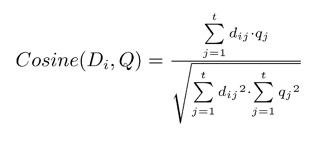

In [ ]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

##### **Cosine Similarity with Document Query**
___________________________________________________
fungsi untuk menampilkan dokumen-dokumen yang memiliki kemiripan dengan query didasarkan pada perhitungan similarity-nya

In [ ]:
def cosine_similarity_T(k, query):
    #print("Cosine Similarity")
    preprocessed_query = preprocessed_query = re.sub("\W+", " ", query).strip()
    tokens = word_tokenize(str(preprocessed_query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] =wordLemmatizer(q_df.q_clean)
    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    #print("\nQuery:", query)
    #print("")
    #print(tokens)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    
    for d in tfidf_tran.A:
        
        d_cosines.append(cosine_sim(query_vector, d))
                    
    out = np.array(d_cosines).argsort()[-k:][::-1]
    #print("")
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    for i,index in enumerate(out):
        a.loc[i,'index'] = str(index)
        a.loc[i,'content'] = df_news['content'][index]
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

##### **Result**
__________________________________________
score didasarkan pada similaritas query dengan tabel "clean_keyword" 

In [ ]:
cosine_similarity_T(5,'system computer')

,index,content,Score
0,2231,computer engr vs. computer science distributio...,0.413638
1,4326,computer engr vs. computer science cs departme...,0.335903
2,2536,report on privacy protecting off line cash ava...,0.293179
3,10818,stand alone editing suite. article i.d. shelle...,0.281526
4,8464,date is stuck university of toronto erindale c...,0.275345
